### PART 1 - EMBEDDINGS

In [26]:
!pip install openai==0.28.1

In [27]:
# import
import pandas as pd
import tiktoken

In [28]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  
max_tokens = 8000

In [29]:
# load & inspect dataset
input_datapath = "./news.csv"
df = pd.read_csv(input_datapath, index_col=0)
df = df.dropna()
df["combined"] = (
    "title: " + df.title.str.strip() + "; Content: " + df.text.str.strip()
)

df.dtypes

title       object
text        object
label       object
combined    object
dtype: object

In [30]:
df.head(2)

,title,text,label,combined
id,,,,
8476.0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,title: You Can Smell Hillary’s Fear; Content: ...
10294.0,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,title: Watch The Exact Moment Paul Ryan Commit...


In [31]:
# retrieves a specific text encoding method
encoding = tiktoken.get_encoding(embedding_encoding)

# add a new column "n_tokens"
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens]
len(df)

6314

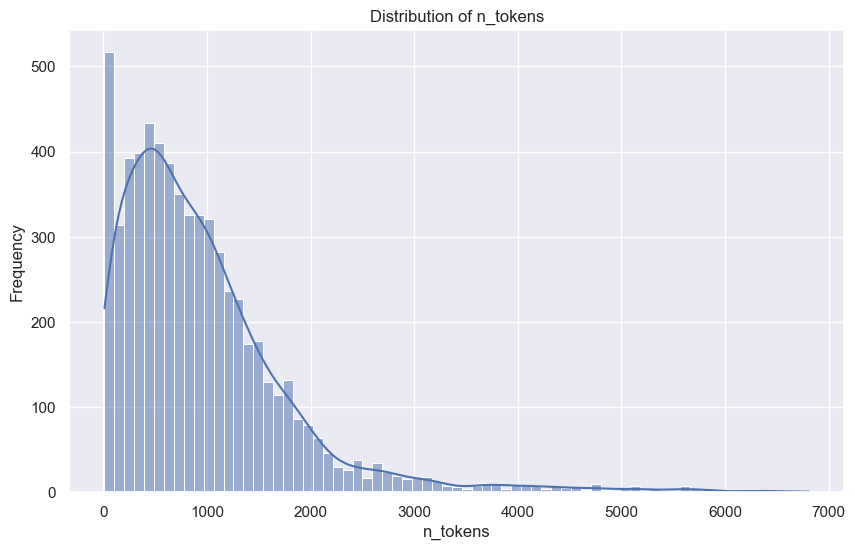

In [32]:
# Distribution (explanation why OpenAI was choosen)
!pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set()

# Create a distribution plot for "n_tokens"
plt.figure(figsize=(10, 6))  
sns.histplot(df['n_tokens'], kde=True) 

# Customization
plt.title('Distribution of n_tokens')
plt.xlabel('n_tokens')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [33]:
from dotenv import load_dotenv
import os
load_dotenv('.env')

True

In [34]:
import openai
openai.api_key_path = None
openai.api_key=os.environ['OAI_KEY']

In [35]:
print(df.dtypes)

title       object
text        object
label       object
combined    object
n_tokens     int64
dtype: object


In [36]:
# convert text into a vector 
from openai.embeddings_utils import get_embedding

# creating a new column "embedding" in the dataframe
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))

# saving the dataframe to a CSV file
df.to_csv("./news_embedded.csv")

### PART 2 - CLASSIFICATION USING EMBEDDINGS

In [37]:
# import
import numpy as np
from ast import literal_eval
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [38]:
# load data
datafile_path = "./news_embedded.csv"

In [39]:
df = pd.read_csv(datafile_path)
# convert string to array
df["embedding"] = df.embedding.apply(literal_eval)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6314 entries, 0 to 6313
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         6309 non-null   float64
 1   title      6314 non-null   object 
 2   text       6314 non-null   object 
 3   label      6314 non-null   object 
 4   combined   6314 non-null   object 
 5   n_tokens   6314 non-null   int64  
 6   embedding  6314 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 345.4+ KB


In [41]:
new_data=[row for row in df.embedding]
    
new_data=np.array(new_data)

In [42]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    new_data, df.label, test_size=0.2, random_state=42
)

In [43]:
# batch
rfc=RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)

1.0

In [44]:
rfc.score(X_test, y_test)

0.9073634204275535

In [45]:
# Make predictions on the test set
preds = rfc.predict(X_test)

In [46]:
# Generate and print the classification report
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

        FAKE       0.88      0.95      0.91       640
        REAL       0.94      0.87      0.90       623

    accuracy                           0.91      1263
   macro avg       0.91      0.91      0.91      1263
weighted avg       0.91      0.91      0.91      1263

